## First Attempt at building a deepsets architecture

In [1]:
import random

import pandas as pd
import numpy as np
import pickle

from numpy import NaN

from set_dataloader import CCD
import time

# Import NN Packages
import torch
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

print(torch.__version__)

from models import VarMultiSetNet
from util import get_dataset, get_mask

1.9.0


### Testing Performance of Trained Model


In [18]:
feature_extractor = nn.Sequential(
    nn.Linear(15, 224),
    nn.ReLU(inplace=False),
    nn.Linear(224, 219),
    nn.ReLU(inplace=False),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(219, 50),
    nn.ReLU(inplace=False)
)

mlp = nn.Sequential(
    nn.Linear(64 + 2, 247),
    nn.ReLU(inplace=False),
    nn.Linear(247, 198),
    nn.ReLU(inplace=False),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(198, 35),
    nn.ReLU(inplace=False),
    nn.Linear(35, 1),
    nn.ReLU(inplace=False)
)

lr = 0.00011649895667343224
criterion = nn.L1Loss()
batch_size = 16
no_epochs = 130

model = VarMultiSetNet(feature_extractor=feature_extractor, mlp=mlp,
                       med_layer=50, reduction='sum')

In [19]:
torch.save(model, "trained_models/{}.pt".format(14))

In [20]:
model = torch.load('trained_models/14.pt', map_location=torch.device('cpu'))

max_set_len = 30
gal = 'qso'
traindata, valdata = get_dataset(num_pixels=3000, max_set_len=max_set_len, gal=gal)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
num_workers = 0 if device == 'cpu:0' else 8

In [21]:


print(f" | Model params: {sum(p.numel() for p in model.parameters() if p.requires_grad)} |")

print()
optimiser = optim.Adam(model.parameters(), lr=lr)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, drop_last=False)

valloader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, shuffle=False, drop_last=False)

mse, r2 = 0, 0

for epoch in range(no_epochs):

    model.train()

    for i, (X1, X2, labels, set_sizes) in enumerate(trainloader):
        # Extract inputs and associated labels from dataloader batch
        X1 = X1.to(device)

        X2 = X2.to(device)

        labels = labels.to(device)

        set_sizes = set_sizes.to(device)

        mask = get_mask(set_sizes, X1.shape[2])
        # Predict outputs (forward pass)

        predictions = model(X1, X2, mask=mask)

        # Zero-out the gradients before backward pass (pytorch stores the gradients)

        optimiser.zero_grad()

        # Compute Loss
        loss = criterion(predictions, labels)

        # Backpropagation
        loss.backward()

        # Perform one step of gradient descent
        optimiser.step()

    model.eval()
    y_pred = np.array([])
    y_gold = np.array([])

    with torch.no_grad():
        for i, (X1, X2, labels, set_sizes) in enumerate(valloader):
            # Extract inputs and associated labels from dataloader batch
            X1 = X1.to(device)

            X2 = X2.to(device)

            labels = labels.to(device)

            set_sizes = set_sizes.to(device)

            mask = get_mask(set_sizes, X1.shape[2])
            # Predict outputs (forward pass)

            predictions = model(X1, X2, mask=mask)
            # Predict outputs (forward pass)

            # Get predictions and append to label array + count number of correct and total
            y_pred = np.append(y_pred, predictions.cpu().detach().numpy())
            y_gold = np.append(y_gold, labels.cpu().detach().numpy())

    try:
        r2 = metrics.r2_score(y_gold, y_pred)
        mse = metrics.mean_squared_error(y_gold, y_pred)
    except:
        print("++++++++++++++++++++")
        print("        NaN         ")
        print("++++++++++++++++++++")

    print("Epoch: ", epoch)
    print("R-2: ", r2)
    print("MSE: ", mse)
    print()
    # Handle pruning based on the intermediate value.

torch.save(model, "trained_models/{}.pt".format(14))


 | Model params: 136564 |

R-2:  -0.026618383182568817
MSE:  0.02640719139235231
R-2:  -0.06533579094969744
MSE:  0.027403099914809086
R-2:  -0.08399028848673562
MSE:  0.02788294022826773
R-2:  0.05304433127716124
MSE:  0.024358067217261147
R-2:  0.06184028880680936
MSE:  0.024131813199439692
R-2:  -0.01975588386154148
MSE:  0.02623067075336037
R-2:  0.09468924106126408
MSE:  0.02328685602408453
R-2:  0.0974531228018467
MSE:  0.0232157620759291
R-2:  -0.005785736055645474
MSE:  0.025871323626002203
R-2:  0.04052929602482158
MSE:  0.024679985211916614
R-2:  0.18823424409037703
MSE:  0.020880644680849055
R-2:  0.21392052778650383
MSE:  0.02021992924770134
R-2:  0.21109615076952293
MSE:  0.02029257928560575
R-2:  0.23321542153696007
MSE:  0.019723616342623748
R-2:  0.28816698604170754
MSE:  0.01831012472299433
R-2:  0.35146915981175775
MSE:  0.01668183455628651
R-2:  0.352299978448648
MSE:  0.016660463823874063
R-2:  0.37125275653309786
MSE:  0.01617295098902563
R-2:  0.34418283582486375


In [22]:
print('++++++++ Session Characteristics +++++++')
print()
print(f"Gal Type: {gal}")
print(f"Training Samples: {traindata.num_pixels}")
print(f"Validation Samples: {valdata.num_pixels}")
print(f"Maximum Set Lengths: {max_set_len}")
print(f"Device: {device}")
print(f"Number of Workers: {num_workers}")
print()
print('+++++++++++++++++++++++++++++++++++++++')

++++++++ Session Characteristics +++++++

Gal Type: qso
Training Samples: 2008
Validation Samples: 990
Maximum Set Lengths: 30
Device: cpu:0
Number of Workers: 0

+++++++++++++++++++++++++++++++++++++++


In [25]:
model = torch.load('trained_models/14.pt', map_location=torch.device('cpu'))

max_set_len = 30
gal = 'qso'
traindata, valdata = get_dataset(num_pixels=20000, max_set_len=max_set_len, gal=gal)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, drop_last=False)

valloader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, shuffle=False, drop_last=False)

mse, r2 = 0, 0

device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
num_workers = 0 if device == 'cpu:0' else 8
print(f"Training Samples: {traindata.num_pixels}")
print(f"Validation Samples: {valdata.num_pixels}")


Training Samples: 13394
Validation Samples: 6595
Training Samples: 13394
Validation Samples: 6595


In [40]:
model.eval()
y_pred = np.array([])
y_gold = np.array([])
y_set_sizes = np.array([])
x2 = np.array([])

with torch.no_grad():
    for i, (X1, X2, labels, set_sizes) in enumerate(trainloader):
        # Extract inputs and associated labels from dataloader batch
        X1 = X1.to(device)

        X2 = X2.to(device)

        labels = labels.to(device)

        set_sizes = set_sizes.to(device)

        mask = get_mask(set_sizes, X1.shape[2])
        # Predict outputs (forward pass)

        predictions = model(X1, X2, mask=mask)
        # Predict outputs (forward pass)

        # Get predictions and append to label array + count number of correct and total
        y_pred = np.append(y_pred, predictions.cpu().detach().numpy())
        y_gold = np.append(y_gold, labels.cpu().detach().numpy())
        y_set_sizes = np.append(y_set_sizes, set_sizes.cpu().detach().numpy())
        x2 = np.append(x2, X2.cpu().detach().numpy())

    r2 = metrics.r2_score(y_gold, y_pred)
    mse = metrics.mean_squared_error(y_gold, y_pred)

    diff = y_gold - y_pred

print("R-2: ", r2)
print("MSE: ", mse)
print(diff)

R-2:  0.5308065964837925
MSE:  0.007209734480148055
[-0.09881625 -0.03531551  0.07321015 ... -0.00868121 -0.06905782
 -0.04350576]


In [4]:
traindata, valdata = get_dataset(num_pixels=20000, max_set_len=30, gal='qso')

trainloader = torch.utils.data.DataLoader(traindata, batch_size=16, shuffle=True,
                                          num_workers=0, drop_last=False)

valloader = torch.utils.data.DataLoader(valdata, batch_size=16, shuffle=False, drop_last=False)

In [5]:
d = trainloader.dataset[:]

In [6]:
x1,x2,train_labels,set_sizes = d

print(x1.shape)
print(x2.mean(axis=0))
print(train_labels.mean())
print(set_sizes.mean())

torch.Size([13392, 64, 30, 15])
tensor([0.0763, 0.0831])
tensor(0.0907)
14.80072641315711


In [7]:
d = valloader.dataset[:]

In [8]:
x1,x2,test_labels,set_sizes = d

print(x1.shape)
print(x2.mean(axis=0))
print(test_labels.mean())
print(set_sizes.mean())

torch.Size([6597, 64, 30, 15])
tensor([0.0780, 0.0827])
tensor(0.2252)
14.815517470062149


In [9]:
import matplotlib.pyplot as plt

In [10]:
print(train_labels.numpy().flatten().shape)

(13392,)


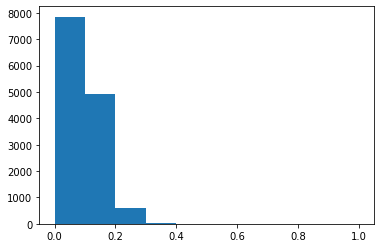

In [11]:
train_labels = train_labels.numpy().flatten()
plt.hist(train_labels, range=[0,1])
plt.show()

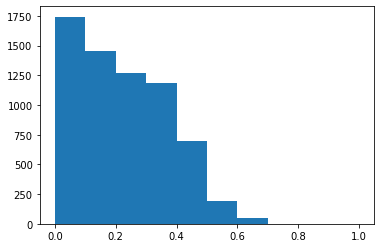

In [12]:
test_labels = test_labels.numpy().flatten()
plt.hist(test_labels, range=[0,1])
plt.show()


19989


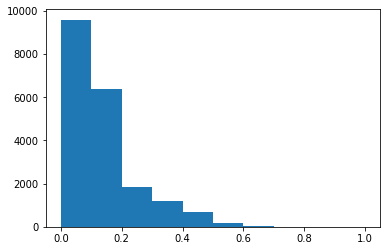

In [13]:
shared = np.append(train_labels, test_labels)
print(len(shared))
plt.hist(shared, range=[0,1])
plt.show()

In [ ]:
diff = np.abs(diff)

print(diff.mean())
print(np.median(diff))
print(diff.max())

In [37]:
diff = np.abs(diff)

print(diff.mean())
print(np.median(diff))
print(diff.max())



0.06455788083512315
0.049366846680641174
0.7136873006820679


## Building a deepsets architecture


## Writing Dataset Utility to pass data in the right format

#### Steps:

1. Build a NN sampling an equal number of CCDs per 256 pixel and pass through deep sets for regression

2. Adapt NN for variable sized inputs

3. Adapt NN to use 64 inputs of size 2048 to then predict density at 256


In [46]:
# noinspection PyAttributeOutsideInit
class SetSequence(Dataset):
    """Processes and Returns a Dataset of Variable Sized Input Sets of Dimensions
    N = Number Pixels of that are returned
    M = Max Size of each Individual Set of CCDs


    """

    def __init__(self, num_pixels=10, max_ccds=30, var_set_len=False):

        with open('../../bricks_data/pixel2ccd_256_non_inclusive.pickle', 'rb') as f:
            self.pixel2ccd_dict = pickle.load(f)
            f.close()

        self.ccd = CCD()
        self.num_features = self.ccd.num_features

        # Dimensions
        self.num_pixels = num_pixels
        self.max_ccds = max_ccds
        self.var_set_len = var_set_len

        df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
        # Randomly Sampling Pixel Indices from Dataframe
        pixel_indices = random.sample(range(len(df_raw)), num_pixels)

        self.df = df_raw.iloc[pixel_indices]
        self.pix_ids = self.df.pixel_id.to_numpy()

        self.initialise_inputs()

        self.initialise_lengths()

        # Target
        self.label = np.random.rand(self.num_pixels * self.max_ccds)

        # Mask Variable Len Sets
        #self.set_max_set_len()

    def set_targets(self, gal_type):
        # Features and inputs:
        self.target = None
        self.target = self.df[gal_type].to_numpy()
        #print(self.target.shape)
        self.scaler_out = preprocessing.MinMaxScaler()
        self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))
        #print(self.target.shape)

    def initialise_lengths(self):
        self.lengths = np.zeros(self.num_pixels, dtype=int)
        if self.var_set_len:
            for i, pix in enumerate(self.pix_ids):
                c = len(self.pixel2ccd_dict[pix])
                if c < self.max_ccds:
                    self.lengths[i] = c
                else:
                    self.lengths[i] = self.max_ccds

        else:
            self.lengths.fill(self.max_ccds)

    def initialise_inputs(self):
        #self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
        self.input = np.zeros((self.num_pixels, self.max_ccds, self.num_features))

        # Iterate through the pixels
        for i, pix in enumerate(self.pix_ids):
            ids = self.pixel2ccd_dict[pix]
            random.shuffle(ids)
            #print(len(ids))
            ids = ids[:self.max_ccds]
            #print(len(ids))
            #print()
            x = self.ccd.get_ccds(ids)
            # Iterate through the CCDs for every pixel
            for j in range(len(ids)):
                self.input[i, j] = x[j]

    def set_max_set_len(self):
        self.index_matrix = -1 * np.ones((self.num_pixels, self.max_ccds), dtype=int)

        # Getting random labels for now, in the future this will be the output densities

        m = 0
        for i in range(self.num_pixels):

            for j in range(self.lengths[i]):
                ''' This code with label == 0 is not yet needed, but this masking will become necessary when I have
                    I have 64 subpixels per pixel and some of those are not covered by CCDs'''
                while self.label[m] == 0:
                    m += 1
                self.index_matrix[i, j] = m
                m += 1

        print(self.lengths)
        print(self.index_matrix)

    def __len__(self):
        return self.num_pixels

    def __getitem__(self, idx):
        x = torch.from_numpy(self.input[idx]).float()
        #x = x.unsqueeze(0)
        y = torch.tensor(self.target[idx, 0]).float()
        #print(y.shape)
        y = y.unsqueeze(-1)
        #print(y.shape)

        #l = torch.tensor(self.lengths[idx])
        l = self.lengths[idx]

        return x, y, l


""" Todo
1. Where to get the data from
2. Scaling --> import an already scaled dataset, this will have to be prepared but should be same for Neural Net
3. Combine larger and smaller dataset
4. Build 64 input channels instead of one, so one more dimension of tensors( NO of Pixels,no_of_subpixels,no_ccds, no_features)
"""

' Todo\n1. Where to get the data from\n2. Scaling --> import an already scaled dataset, this will have to be prepared but should be same for Neural Net\n3. Combine larger and smaller dataset\n4. Build 64 input channels instead of one, so one more dimension of tensors( NO of Pixels,no_of_subpixels,no_ccds, no_features)\n'

In [47]:
traindata = SetSequence(var_set_len=True)
traindata.set_targets('lrg')
x, y, l = traindata.__getitem__(3)
print(l.shape)
print(x.shape)
print(y.shape)







()
torch.Size([30, 9])
torch.Size([1])


## Building the Actual Network Architecture



In [66]:
from deepset_layers import InvLinear


class SetNet(nn.Module):
    def __init__(self, n_features=5, n_output=3, reduction='sum'):
        super(SetNet, self).__init__()

        # Takes an Input Tensor and applies transformations to last layer --> features
        # Output of Feature Layer: Tensor with Max.CCDs elements, which can now be passed to Set Layer
        self.feature_extractor = nn.Sequential(
            nn.Linear(n_features, 7),
            nn.ReLU(inplace=True),
            nn.Linear(7, 5),
            nn.ReLU(inplace=True),
            nn.Linear(5, n_output),
            nn.ReLU(inplace=True)
        )

        self.adder = InvLinear(3, 1, reduction=reduction, bias=True)

        # Invariant Layer Influenced by Code from DPernes, but adapted for the current regression task instead of CNN

    def forward(self, X, mask=None):
        y = self.feature_extractor(X)

        y = self.adder(y, mask=mask)
        return y


In [18]:
traindata = SetSequence(var_set_len=True)
traindata.set_targets('lrg')
x, y, l = traindata.__getitem__(3)
print(l)
print(y)
print(y.shape)

(10,)
(10, 1)
9
tensor([[0.5417]])
torch.Size([1, 1])


In [78]:
net = SetNet()
y = net.forward(x)
print(y)


INVLAYER: torch.Size([1, 30, 3])
tensor([[-8.7350]], grad_fn=<AddBackward0>)


In [80]:
#Work out masking logic
device = 'cpu'

x = x.to(device)
y = y.to(device)
l = l.to(device)


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


mask = get_mask(l, x.shape[1])
print(mask)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])


###  Hyperparameters and Training Loops

In [33]:
# Defining Loss
criterion = nn.MSELoss()

#Defining Hyperparemeters
no_epochs = 100  #very low, but computational power not sufficient for more iterations
batch = 4
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
#optimiser = optim.Adam(model.parameters(), lr=learning_rate)

galaxy_types = ['lrg', 'elg', 'qso']
device = 'cpu'


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


In [34]:
traindata = SetSequence(num_pixels=1000, var_set_len=True)

In [35]:
for gal in galaxy_types:
    model = SetNet(n_features=traindata.num_features, reduction='max').to(device)
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    print("GALAXY TYPE: ", gal)
    print()
    traindata.set_targets(gal_type=gal)

    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0
        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle=True)

        for i, (X, labels, set_sizes) in enumerate(trainloader):
            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            X = X.to(device)

            labels = labels.to(device)
            set_sizes = set_sizes.to(device)

            mask = get_mask(set_sizes, X.shape[1])

            #Predict outputs (forward pass)

            predictions = model(X, mask=mask)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()
            #Backpropagation
            loss.backward()
            #Perform one step of gradient descent
            optimiser.step()
            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()

        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)

    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to train the model")
    print()

GALAXY TYPE:  lrg

Loss for Epoch 0 :  2942.1800325997174
Loss for Epoch 10 :  3.680534098879434
Loss for Epoch 20 :  2.884592419693945
Loss for Epoch 30 :  2.765893154341029
Loss for Epoch 40 :  2.5631455073598772
Loss for Epoch 50 :  2.684168670588406
Loss for Epoch 60 :  2.5554687872645445
Loss for Epoch 70 :  2.4053838056570385
Loss for Epoch 80 :  2.4015086796716787
Loss for Epoch 90 :  2.399972525483463

0.39641 minutes (23.8 seconds) taken to train the model

GALAXY TYPE:  elg

Loss for Epoch 0 :  27871.49012487009
Loss for Epoch 10 :  8.458283477695659
Loss for Epoch 20 :  4.994630630942993
Loss for Epoch 30 :  4.833354047266766
Loss for Epoch 40 :  4.84361100976821
Loss for Epoch 50 :  4.83717059326591
Loss for Epoch 60 :  4.820220751920715
Loss for Epoch 70 :  4.846069120801985
Loss for Epoch 80 :  4.8225392025779
Loss for Epoch 90 :  4.808886545091809

0.42237 minutes (25.3 seconds) taken to train the model

GALAXY TYPE:  qso

Loss for Epoch 0 :  14189.960423341021
Loss for 

# MultiSetNet

### Trying to Build a Network Capable of Processing 64 Subpixels Simultaneously

Initialise Inputs Function

In [ ]:
ccd = CCD()

In [ ]:
num_pixels = 2
num_subpixels = 4
max_ccds = 5
num_features = 9
#df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
# Randomly Sampling Pixel Indices from Dataframe
#pixel_indices = random.sample(range(len(df_raw)), num_pixels)
pix_ids = [1, 2]
pixel2subpixel_dict = {1: [11, 12, 13, 14], 2: [21, 22, 23, 24]}
subpixel2ccd_dict = {11: [111, 112, 113, 114], 12: [121, 122, 123, 124, 125], 13: [131, 132, 133, 134, 135],
                     14: [141, 142, 143, 144, 145],
                     21: [211, 212, 213, 214, 215], 22: [221, 222], 23: [231, 232, 233, 234, 235],
                     24: [241, 242, 243, 244, 245]}

In [ ]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Initialise Lengths Function

In [ ]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

In [ ]:
# GetItem Function
idx = 0
x = torch.from_numpy(input[idx]).float()

#l = torch.tensor(self.lengths[idx])
l = lengths[idx]

print(x.shape)
print(l.shape)

In [33]:
# noinspection PyAttributeOutsideInit
class MultiSetSequence(Dataset):
    """Processes and Returns a Dataset of Variable Sized Input Sets of Dimensions
    N = Number SubPixels of that are returned --> usually 64
    M = Max Size of each Individual Set of CCDs
    """

    def __init__(self, num_pixels=1000, num_subpixels=64, max_ccds=30, num_features=9):

        with open('../../bricks_data/mini_multiset.pickle', 'rb') as f:
            self.mini_multiset = pickle.load(f)
            f.close()

        # Initialise DataSet
        self.num_pixels = num_pixels
        self.num_features = num_features
        self.input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
        self.lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
        self.lrg = np.zeros(num_pixels)
        self.elg = np.zeros(num_pixels)
        self.qso = np.zeros(num_pixels)

        self.initialise_inputs()

    def set_targets(self, gal_type):
        # Features and inputs:
        self.target = None
        if gal_type == 'lrg':
            self.target = self.lrg
        if gal_type == 'elg':
            self.target = self.elg
        if gal_type == 'qso':
            self.target = self.qso
        self.scaler_out = preprocessing.MinMaxScaler()
        self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))

    def initialise_inputs(self):
        for i, pix in enumerate(self.mini_multiset):
            if i >= self.num_pixels:
                break
            self.input[i] = self.mini_multiset[pix][0]
            self.lengths[i] = self.mini_multiset[pix][1]
            self.lrg[i] = self.mini_multiset[pix][2]
            self.elg[i] = self.mini_multiset[pix][3]
            self.qso[i] = self.mini_multiset[pix][4]

    def __len__(self):
        return self.num_pixels

    def __getitem__(self, idx):
        x = torch.from_numpy(self.input[idx]).float()
        #x = x.unsqueeze(0)
        y = torch.tensor(self.target[idx, 0]).float()
        #print(y.shape)
        y = y.unsqueeze(-1)
        #print(y.shape)

        #l = torch.tensor(self.lengths[idx])
        l = self.lengths[idx]

        return x, y, l



In [ ]:
traindata = MultiSetSequence(num_pixels=10)
traindata.set_targets('lrg')
x, y, l = traindata.__getitem__(3)
print(l.shape)
print(x.shape)
print(y.shape)



In [48]:
from deepset_layers import InvLinear


class MultiSetNet(nn.Module):
    def __init__(self, n_features=9, n_output=3, n_subpix=64, reduction='sum'):
        super(MultiSetNet, self).__init__()

        # Takes an Input Tensor and applies transformations to last layer --> features
        # Output of Feature Layer: Tensor with Max.CCDs elements, which can now be passed to Set Layer
        self.feature_extractor = nn.Sequential(
            nn.Linear(n_features, 7),
            nn.ReLU(inplace=True),
            nn.Linear(7, 5),
            nn.ReLU(inplace=True),
            nn.Linear(5, n_output),
            nn.ReLU(inplace=True)
        )
        self.adder = InvLinear(3, 1, reduction=reduction, bias=True)

        self.mlp = nn.Sequential(
            nn.Linear(n_subpix, 2),
            nn.ReLU(inplace=True),
            nn.Linear(2, 1),
            nn.ReLU(inplace=True)
        )

        # Invariant Layer Influenced by Code from DPernes, but adapted for the current regression task instead of CNN

    def forward(self, X, mask=None):
        y = self.feature_extractor(X)
        y = self.adder(y, mask=mask)

        y = self.mlp(y.T)
        return y


""" TODO
1. Train Loop with Batching
2. Masking Procedure, need to mask out singular values on top of those that have no CCDs
3. How to actually feed real data into the system to see if it can learn
"""

' TODO\n1. Train Loop with Batching\n2. Masking Procedure, need to mask out singular values on top of those that have no CCDs\n3. How to actually feed real data into the system to see if it can learn\n'

In [44]:
net = MultiSetNet()
print(x.shape)
y = net.forward(x)
print(y)


torch.Size([64, 30, 9])
torch.Size([64, 30, 3])
tensor([[0.]], grad_fn=<ReluBackward1>)


In [67]:
# Defining Loss
criterion = nn.MSELoss()

#Defining Hyperparemeters
no_epochs = 100  #very low, but computational power not sufficient for more iterations
batch = 1
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
#optimiser = optim.Adam(model.parameters(), lr=learning_rate)

galaxy_types = ['lrg', 'elg', 'qso']
device = 'cpu'


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


In [68]:
traindata = MultiSetSequence(num_pixels=100)

In [69]:
for gal in galaxy_types:
    model = MultiSetNet(n_features=traindata.num_features, reduction='sum').to(device)
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    print("GALAXY TYPE: ", gal)
    print()
    traindata.set_targets(gal_type=gal)

    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0
        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle=True)

        for i, (X, labels, set_sizes) in enumerate(trainloader):
            #print(X.shape)
            #print(labels.shape)
            #print(set_sizes)
            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            X = X.squeeze().to(device)

            labels = labels.to(device)
            #set_sizes = set_sizes.to(device)

            #mask = get_mask(set_sizes, X.shape[1])

            #Predict outputs (forward pass)

            # Not yet doing any masking
            predictions = model(X)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()
            #Backpropagation
            loss.backward()
            #Perform one step of gradient descent
            optimiser.step()
            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()

        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)
    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to train the model")
    print()

GALAXY TYPE:  lrg

Loss for Epoch 0 :  21.203732424415648
Loss for Epoch 10 :  21.21518995705992
Loss for Epoch 20 :  21.21518995705992
Loss for Epoch 30 :  21.21518995705992
Loss for Epoch 40 :  21.21518995705992
Loss for Epoch 50 :  21.21518995705992
Loss for Epoch 60 :  21.21518995705992
Loss for Epoch 70 :  21.21518995705992
Loss for Epoch 80 :  21.21518995705992
Loss for Epoch 90 :  21.21518995705992

0.19455 minutes (11.7 seconds) taken to train the model

GALAXY TYPE:  elg

Loss for Epoch 0 :  38.964210975915194
Loss for Epoch 10 :  38.91034494712949
Loss for Epoch 20 :  38.91034494712949
Loss for Epoch 30 :  38.91034494712949
Loss for Epoch 40 :  38.91034494712949
Loss for Epoch 50 :  38.91034494712949
Loss for Epoch 60 :  38.91034494712949
Loss for Epoch 70 :  38.91034494712949
Loss for Epoch 80 :  38.91034494712949
Loss for Epoch 90 :  38.91034494712949

0.23638 minutes (14.2 seconds) taken to train the model

GALAXY TYPE:  qso

Loss for Epoch 0 :  18.97755779325962
Loss for 

# Model Training and Comparison

### Set-Net

In [170]:
import importlib
import sys

importlib.reload(sys.modules['utilities'])
from utilities import train, multi_train, MultiSetTrainer

In [ ]:
train(1000)

### Multi-Set-Net

In [77]:
multi_train(1000)


GALAXY TYPE:  lrg

Loss for Epoch 0 :  10.053878550264926
Loss for Epoch 10 :  10.053878550264926
Loss for Epoch 20 :  10.053878550264926
Loss for Epoch 30 :  10.053878550264926
Loss for Epoch 40 :  10.053878550264926
Loss for Epoch 50 :  10.053878550264926
Loss for Epoch 60 :  10.053878550264926
Loss for Epoch 70 :  10.053878550264926
Loss for Epoch 80 :  10.053878550264926
Loss for Epoch 90 :  10.053878550264926

1.7579 minutes (1.05e+02 seconds) taken to train the model

GALAXY TYPE:  elg

Loss for Epoch 0 :  11629.811594213443
Loss for Epoch 10 :  42.34878332098149
Loss for Epoch 20 :  42.36339263490362
Loss for Epoch 30 :  42.325412895846654
Loss for Epoch 40 :  42.393384256566165
Loss for Epoch 50 :  42.373732197336295
Loss for Epoch 60 :  42.40096284180902
Loss for Epoch 70 :  42.24797562570515
Loss for Epoch 80 :  42.28472199212819
Loss for Epoch 90 :  42.39563592875416

1.7813 minutes (1.07e+02 seconds) taken to train the model

GALAXY TYPE:  qso

Loss for Epoch 0 :  214.11590

In [171]:
trainer = MultiSetTrainer(num_pixels=1000)

Training Samples: 670
Test Samples: 330


In [172]:
trainer.train()

GALAXY TYPE:  lrg

torch.Size([1, 64])
tensor([[28, 23, 21, 30, 30, 30, 30, 30, 30, 30, 27, 30, 27, 27, 23, 30, 30, 30,
         30, 30, 30, 30, 28, 30, 30, 30, 27, 30, 24, 24, 24, 24, 24, 24, 23, 21,
         28, 26, 28, 28, 28, 21, 27, 21, 21, 21, 21, 21, 20, 22, 24, 30, 30, 24,
         24, 28, 30, 30, 19, 26, 26, 25, 28, 30]])
<class 'torch.Tensor'>
tensor([[ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ...,  True,  True,  True]])


/Users/edgareggert/astrostatistics/models/deep_set/utilities.py:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # set_sizes = set_sizes.to(device)


In [166]:
trainer.test()


MultiSetNet R^2 for lrg :  -1.4573048083786349.
MultiSetNet MSE for lrg :  0.013348963645229783.

MultiSetNet R^2 for elg :  -2.142983122931937.
MultiSetNet MSE for elg :  0.1886151816532751.

MultiSetNet R^2 for qso :  -2.0842765440713604.
MultiSetNet MSE for qso :  0.16178952133573077.


## Todo 1: Working out Masking Logic

In [65]:
from datasets import SetSequence
import torch
import numpy as np
import math

from torch import nn
from torch.nn import init


In [40]:
def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1) < sizes.reshape(-1, 1))


In [23]:
traindata = SetSequence(num_pixels=10, var_set_len=True)
traindata.set_targets(gal_type='lrg')

In [71]:
device = 'cpu'
X, Y, set_sizes = traindata.__getitem__(3)
X = X.unsqueeze(0).to(device)

In [72]:
print(X.shape, Y.shape, set_sizes)

torch.Size([1, 30, 8]) torch.Size([1]) 14


In [64]:
print(set_sizes.reshape(-1, 1))

[[14]]


In [109]:
mask = get_mask(set_sizes, X.shape[1])
print(type(mask))


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


set_sizes = torch.Tensor(set_sizes).to(device)
mask = get_mask(set_sizes, X.shape[1])
print(type(mask))

AttributeError: 'numpy.int64' object has no attribute 'device'

In [80]:
class InvLinear(nn.Module):
    r"""Permutation invariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """

    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(InvLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        assert reduction in ['mean', 'sum', 'max',
                             'min'], '\'reduction\' should be \'mean\'/\'sum\'\'max\'/\'min\', got {}'.format(reduction)

        self.reduction = reduction

        self.beta = nn.Parameter(torch.Tensor(self.in_features,
                                              self.out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, self.out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        init.xavier_uniform_(self.beta)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.beta)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to a vector y of dimension out_features,
        through a permutation invariant linear transformation of the form:
            $y = \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N vectors of dimension out_features (tensor with shape (N, out_features))
        """
        print("INVLAYER:", X.shape)
        N, M, _ = X.shape
        print(N, M)
        device = X.device
        y = torch.zeros(N, self.out_features).to(device)
        print(y)
        print(y.shape)

        if mask is None:
            mask = torch.ones(N, M).byte().to(device)

        if self.reduction == 'mean':
            sizes = mask.float().sum(dim=1).unsqueeze(1)
            Z = X * mask.unsqueeze(2).float()
            y = (Z.sum(dim=1) @ self.beta) / sizes


        elif self.reduction == 'sum':
            Z = X * mask.unsqueeze(2).float()
            y = Z.sum(dim=1) @ self.beta

        elif self.reduction == 'max':
            Z = X.clone()
            Z[~mask] = float('-Inf')
            y = Z.max(dim=1)[0] @ self.beta

        else:  # min
            Z = X.clone()
            Z[~mask] = float('Inf')
            y = Z.min(dim=1)[0] @ self.beta

        if self.bias is not None:
            y += self.bias

        return y

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, reduction={}'.format(
            self.in_features, self.out_features,
            self.bias is not None, self.reduction)

In [81]:
layer = InvLinear(in_features=8, out_features=3, bias=True, reduction='sum')

print(layer.bias)

Parameter containing:
tensor([[-0.2822, -0.2697, -0.3711]], requires_grad=True)


In [127]:
beta = nn.Parameter(torch.Tensor(4, 3))
print(beta)
init.xavier_uniform_(beta)
print(beta)

feature_extractor = nn.Sequential(
    nn.Linear(8, 7),
    nn.ReLU(inplace=True),
    nn.Linear(7, 5),
    nn.ReLU(inplace=True),
    nn.Linear(5, 4),
    nn.ReLU(inplace=True)
)

Parameter containing:
tensor([[ 0.0000e+00, -1.5846e+29,  5.0240e+15],
        [-4.6577e-10,  1.2612e-44,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], requires_grad=True)
Parameter containing:
tensor([[ 0.7819, -0.0058,  0.0651],
        [-0.0663,  0.6536,  0.0455],
        [ 0.6011, -0.5926, -0.6082],
        [-0.1283, -0.3870,  0.8119]], requires_grad=True)


In [134]:
def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1) < sizes.reshape(-1, 1))

tensor([[0.3149, 0.1904, 0.0078, 0.6765, 0.7230, 0.0260, 1.0000, 0.0000],
        [0.1332, 0.1242, 0.0032, 0.5936, 0.6804, 0.0285, 1.0000, 2.0000],
        [0.2082, 0.1904, 0.0082, 0.6525, 0.6998, 0.0260, 1.0000, 1.0000],
        [0.2082, 0.2318, 0.0055, 0.6495, 0.6985, 0.0132, 1.0000, 1.0000],
        [0.0815, 0.1531, 0.0043, 0.6496, 0.7003, 0.0126, 1.0000, 1.0000],
        [0.3332, 0.2069, 0.0070, 0.6758, 0.7228, 0.0274, 1.0000, 0.0000],
        [0.3066, 0.1531, 0.0049, 0.6741, 0.7200, 0.0285, 1.0000, 0.0000],
        [0.1199, 0.2235, 0.0036, 0.6415, 0.7069, 0.0283, 1.0000, 1.0000],
        [0.4116, 0.1366, 0.0037, 0.5766, 0.6879, 0.0132, 1.0000, 2.0000],
        [0.1665, 0.1490, 0.0042, 0.5767, 0.6709, 0.0281, 1.0000, 2.0000],
        [0.4166, 0.1324, 0.0034, 0.5763, 0.6901, 0.0260, 1.0000, 2.0000],
        [0.0865, 0.1366, 0.0053, 0.6507, 0.7010, 0.0251, 1.0000, 1.0000],
        [0.1349, 0.1945, 0.0066, 0.6565, 0.7018, 0.0277, 1.0000, 1.0000],
        [0.3332, 0.2442, 0.0073, 0.676

In [139]:
device = 'cpu'
traindata = SetSequence(num_pixels=10, var_set_len=True)
traindata.set_targets('lrg')
trainloader = torch.utils.data.DataLoader(traindata, batch_size=4, shuffle=True)

In [173]:
for batch in trainloader:
    X, Y, set_sizes = batch[0], batch[1], batch[2]
    break
print(X.shape)
print(Y.shape)
print(set_sizes.shape)
X = feature_extractor(X)
print(X)

torch.Size([4, 30, 8])
torch.Size([4, 1])
torch.Size([4])
tensor([[[0.0000, 0.0000, 0.0000, 0.4102],
         [0.0000, 0.0000, 0.0000, 0.4108],
         [0.0000, 0.0000, 0.0000, 0.4089],
         [0.0251, 0.0000, 0.0000, 0.3924],
         [0.0000, 0.0000, 0.0000, 0.4237],
         [0.0000, 0.0000, 0.0000, 0.4251],
         [0.0271, 0.0000, 0.0000, 0.3918],
         [0.0000, 0.0000, 0.0000, 0.4093],
         [0.0272, 0.0000, 0.0000, 0.3917],
         [0.0000, 0.0000, 0.0000, 0.3913],
         [0.0000, 0.0000, 0.0000, 0.4240],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.3793],
         [0.0407, 0.0000, 0.0000, 0.379

In [174]:
print(set_sizes)
set_sizes = torch.tensor(set_sizes).to(device)
print(set_sizes)

N, M, _ = X.shape
print(N, M)
device = X.device
y = torch.zeros(N, 3).to(device)
print(y)

tensor([11, 11,  9, 11])
tensor([11, 11,  9, 11])
4 30
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


<ipython-input-174-80fa19fef633>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  set_sizes = torch.tensor(set_sizes).to(device)


In [176]:
#mask = torch.ones(N, M).byte().to(device)
mask = get_mask(set_sizes, X.shape[1])

print(mask)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])


In [177]:
sizes = mask.float().sum(dim=1).unsqueeze(1)
print(sizes)
mask = mask.unsqueeze(2).float()
print(mask)
print(X)
Z = X * mask
print(Z)
y = Z.sum(dim=1)
y = y @ beta
print(y)
y = y / sizes

tensor([[11.],
        [11.],
        [ 9.],
        [11.]])
tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
     

In [ ]:
# Mean
sizes = mask.float().sum(dim=1).unsqueeze(1)
Z = X * mask.unsqueeze(2).float()
y = (Z.sum(dim=1) @ beta) / sizes

In [82]:
y = layer.forward(X, mask)
print(y)



INVLAYER: torch.Size([1, 30, 8])
1 30
tensor([[0., 0., 0.]])
torch.Size([1, 3])
None


## Todo 2: Feeding Info later in NN


In [313]:
import importlib
import sys

importlib.reload(sys.modules['datasets'])
from datasets import MultiSetSequence

In [336]:
traindata = MultiSetSequence()
traindata.set_targets('lrg')
trainloader = torch.utils.data.DataLoader(traindata, batch_size=1, shuffle=True)

In [337]:
for batch in trainloader:
    print(len(batch))
    X1, X2, Y, L = batch[0], batch[1], batch[2], batch[3]
    break
X = X1.squeeze()

X2 = X2.reshape(-1, 1)


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1) < sizes.reshape(-1, 1))


mask = get_mask(L, X.shape[1])

4


In [338]:
importlib.reload(sys.modules['models'])
from models import MultiSetNet, VarMultiSetNet

torch.Size([64, 30, 9])
torch.Size([64, 30, 3])
X1,X2
torch.Size([64, 1])
torch.Size([2, 1])
torch.Size([66, 1])
torch.Size([1, 1])
tensor([[0.3807]], grad_fn=<ReluBackward1>)


In [339]:
model = MultiSetNet()

print(X.shape)
X1 = model.feature_extractor(X)
print(X1.shape)
X1 = model.adder(X1, mask=mask)
print("X1,X2")
print(X1.shape)
print(X2.shape)
X1 = torch.cat((X1, X2), dim=0)
print(X1.shape)
X1 = model.mlp(X1.T)
print(X1.shape)
print(X1)

torch.Size([64, 30, 9])
torch.Size([64, 30, 3])
X1,X2
torch.Size([64, 1])
torch.Size([2, 1])
torch.Size([66, 1])
torch.Size([1, 1])
tensor([[0.3487]], grad_fn=<ReluBackward1>)


In [340]:
y = model.forward(X, X2, mask=mask)
print(y)

tensor([[0.3487]], grad_fn=<ReluBackward1>)


### Training a model with new Multisets architecture

In [36]:

import importlib
import sys

importlib.reload(sys.modules['trainer'])
importlib.reload(sys.modules['models'])
importlib.reload(sys.modules['datasets'])
importlib.reload(sys.modules['deepset_layers'])



<module 'deepset_layers' from '/Users/edgareggert/astrostatistics/models/deep_set/deepset_layers.py'>

In [37]:
import importlib
import sys

importlib.reload(sys.modules['trainer'])
from trainer import MultiSetTrainer

In [38]:
trainer = MultiSetTrainer(num_pixels=1000)



Training Samples: 670
Test Samples: 330


In [39]:
trainer.train()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [32]:
trainer.test()


IndexError: list index out of range

In [4]:
trainer.count_parameters()



## Todo 3: MultiBatching in Multisets



## Todo 4: Clean-Up everything and Deploy remotely




Begin by Increasing Number of Features

In [2]:
import importlib
import sys

importlib.reload(sys.modules['set_dataloader'])

from set_dataloader import CCD

ccd = CCD()



In [6]:
import numpy as np

In [11]:
ccd_cuts = ccd.ccd_cuts
m = ccd_cuts > 0
ccd_cuts_pos = ccd_cuts[m]
print(len(ccd_cuts_pos))

unique, counts = np.unique(ccd_cuts, return_counts=True)

for i in range(len(unique)):
    print(unique[i], counts[i])

1544600
0 5231831
16384 593758
16400 2
16416 94
16448 2660
16480 44
16496 11
16512 10
16544 16
16896 26
16928 1
16992 1
18432 232
18464 2
18496 2
18528 6
18544 1
18560 1
18944 23
18976 11
19040 45
20480 206
20512 9
22528 5
23040 1
49152 11637
49160 1894
49184 48
49192 13
49216 216804
49224 196
49232 4896
49248 1632
49256 2
49264 2029
49280 80
49288 60
49312 1
49328 1
49408 1165
49416 240
49440 5
49448 1
49456 1
49472 1440
49480 2
49488 64
49504 13
49520 2
49664 8797
49672 122
49696 15
49704 1
49728 3706
49736 4
49744 17
49760 256
49776 25
49824 1
49920 1248
49928 8
49952 7
49984 453
50000 7
50016 33
50032 5
50176 2
50184 61
50208 9
50216 21
50240 29
50248 6
50256 334
50272 89
50280 4
50288 156
50432 12
50440 9
50464 9
50472 9
50480 1
50496 213
50512 23
50528 188
50544 87
50592 14
50608 5
50696 9
50720 2
50728 4
50752 334
50784 555
50800 176
50848 2
50944 13
50952 4
50976 6
50984 1
51008 24
51024 1
51040 35
51056 4
51200 489
51208 572
51232 30
51240 4
51264 10815
51272 78
51280 2012
512

In [14]:
print(ccd_cuts[6])
bin(ccd_cuts[6])

bin(248416)

49216


'0b111100101001100000'

In [18]:
c = 0
for i in range(18):
    t = 2 ** i
    print(t)
    c += t

print(c)

1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536
131072
262143


In [4]:

import importlib
import sys

importlib.reload(sys.modules['utilities'])
from utilities import MultiSetTrainer

In [5]:
trainer = MultiSetTrainer(num_pixels=1500)

Training Samples: 1005
Test Samples: 495


In [11]:
print(trainer.traindata.lengths[0])

[ 6  9  9  9  9  6  6  6  6  6  7  7  7  7  7  9  9  9  9  8  8 12  9  9
  9  9  9  9  9  9  9  9  9  9  9  9 12  9  9  9  9  9  9  3  6  6  6  6
  6 12 12 12  6  9 12 12 12  9 12 11  5  9  9 10]


In [1]:
import pickle

with open('../../bricks_data/multiset.pickle', 'rb') as f:
    mini_multiset = pickle.load(f)
    f.close()

In [2]:
from datasets import MultiSetSequence

data = MultiSetSequence(dict=mini_multiset, num_pixels=20000)




In [3]:
print(data.num_pixels)

19989
